In [1]:
import xarray as xr
import pandas as pd
from utils.metrics import find_quantile_index, compute_cdf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from utils.plot_config import set_matplotlib_config

set_matplotlib_config()
SAVE_DIR = Path('../figures/')

In [2]:
exp = xr.open_zarr(
    '/net/argon/landclim/kraftb/machflow_engression/runs_expectiles/default/xval/fold_000/preds.zarr/'
).sel(time=slice('2012', '2016'))
exp = exp.where((exp.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod']].compute()

eng = xr.open_zarr(
    '/net/argon/landclim/kraftb/machflow_engression/runs_timesplit/combined.zarr/'
).sel(time=slice('2012', '2016'))
eng = eng.where((eng.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod']].compute()

pred = eng.Qmm_mod
obs = eng.Qmm

/home/kraftb/.conda/envs/engression/lib/python3.10/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [3]:
quantiles = np.arange(start=0.01, stop=1.0, step=0.01)
quantile_values = pred.quantile(quantiles, dim='member', skipna=False)

quantile_indices = xr.apply_ufunc(
    find_quantile_index,
    obs.compute(),                                # Observations with ["time"]
    quantile_values.compute(),                    # Quantiles with ["quantile", "time"]
    input_core_dims=[[], ['quantile']], # Observations have no "quantile", quantiles do
    output_core_dims=[[]],              # Output is scalar per observation
    vectorize=True,                     # Apply function element-wise
    dask='parallelized',                # Enable Dask parallelization if needed
    output_dtypes=[np.int16],           # Output type
)
expectiles = exp.member.values[1:-1]

cdf = xr.apply_ufunc(
    compute_cdf,
    quantile_indices,                   # Observations with ["time"]
    input_core_dims=[['time']],               # Observations have no "quantile", quantiles do
    output_core_dims=[['time']],              # Output is scalar per observation
    exclude_dims={'time'},
    vectorize=True,                     # Apply function element-wise
    dask="parallelized",                # Enable Dask parallelization if needed
    output_dtypes=[np.float32],           # Output type
    kwargs={'num_quantiles': len(expectiles)}
)
cdf = cdf.rename({'time': 'quantile'})
cdf['quantile'] = np.arange(0.01, 1, 0.01)
cdf = xr.Dataset({'cdf': cdf})

cdf['rss'] = ((cdf['cdf'] - cdf['quantile']) ** 2).sum(dim='quantile')

cdf_df = cdf['cdf'].median('station').to_dataframe(name='CDF').reset_index()
rss_df = cdf['rss'].median('station').to_dataframe(name='RSS').reset_index()

NSE = 1 - ((obs - pred.median('member')) ** 2).sum('time') / ((obs - obs.mean('time')) ** 2).sum('time')
nse_df = NSE.median('station').to_dataframe(name='NSE').reset_index()
metric_df = pd.merge(rss_df, nse_df)

metric_df.rename(columns={'beta': 'Beta', 'esl': 'ESL', 'nl': 'NL'}, inplace=True)
cdf_df.rename(columns={'beta': 'Beta', 'esl': 'ESL', 'nl': 'NL', 'quantile': 'Quantile'}, inplace=True)

best_index = np.argmin(metric_df.RSS)
best_config = metric_df.loc[best_index]
best_config = best_config.drop(columns=['RSS', 'NSE'])

# Filter cdf_df to only include the best configuration
cdf_df_best = cdf_df.loc[
    (cdf_df['Beta']==best_config['Beta']) &
    (cdf_df['ESL']==best_config['ESL']) &
    (cdf_df['NL']==best_config['NL'])]

In [4]:
def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            # Check if any solution dominates the current one
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True  # The current one is always efficient
    return is_efficient

In [5]:
metr_val = metric_df[['RSS', 'NSE']].values
metr_val[:, 1] = 1 - metr_val[:, 1]
pareto_front_mask = is_pareto_efficient(metr_val)
metric_df['Pareto'] = pareto_front_mask

In [6]:
metr_val_norm = (metr_val - metr_val.min(axis=0, keepdims=True)) / (metr_val.max(axis=0, keepdims=True) - metr_val.min(axis=0, keepdims=True))
best_combined_loss_index = np.argmin(metr_val_norm.sum(1))

In [7]:
metric_df.iloc[best_combined_loss_index]

Beta          0.67
ESL              5
NL             100
RSS       0.804621
NSE       0.873602
Pareto        True
Name: 11, dtype: object

/tmp/ipykernel_20968/2113372206.py:5: UserWarning: 
The palette list has fewer values (1) than needed (30) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=cdf_df, x='Quantile', y='CDF', hue=cdf_df[['Beta', 'ESL', 'NL']].apply(tuple, axis=1), legend=False, ax=ax, palette=['0.5'], lw=0.7, zorder=0, label='Calibration median across\nstations per configuration')


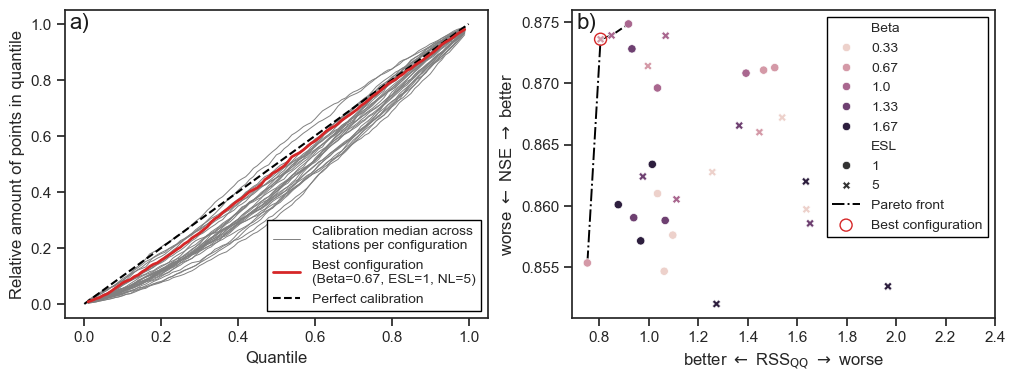

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]

sns.lineplot(data=cdf_df, x='Quantile', y='CDF', hue=cdf_df[['Beta', 'ESL', 'NL']].apply(tuple, axis=1), legend=False, ax=ax, palette=['0.5'], lw=0.7, zorder=0, label='Calibration median across\nstations per configuration')
best_index = np.argmin(rss_df.RSS)
sns.lineplot(
    data=cdf_df_best,
    x='Quantile',
    y='CDF',
    color='tab:red',
    legend=False,
    ax=ax,
    lw=2.0,
    zorder=2,
    label='Best configuration\n' + f"(Beta={best_config['Beta']}, ESL={int(best_config['ESL'])}, NL={int(best_config['NL'])})")
ax.plot([0, 1], [0, 1], color='black', lw=1.5, ls='--', zorder=1, label='Perfect calibration')

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles=handles[-3:], labels=labels[-3:], loc='lower right', bbox_to_anchor=(1.0, 0.0))
ax.set_xlabel('Quantile')
ax.set_ylabel('Relative amount of points in quantile')

ax = axes[1]

sns.scatterplot(data=metric_df, x='RSS', y='NSE', hue='Beta', style='ESL', zorder=1, ax=ax)

pareto_sorted = metric_df[metric_df.Pareto].sort_values(by='NSE')

for i in range(len(pareto_sorted) - 1):
    a = pareto_sorted.iloc[i]
    b = pareto_sorted.iloc[i + 1]
    ax.plot(
        [a.RSS, b.RSS], [a.NSE, b.NSE],
        color='black', lw=1.4, ls='-.', zorder=0, label='Pareto front' if i == 0 else None
    )

ax.scatter(
    [metric_df.iloc[best_combined_loss_index].RSS], [metric_df.iloc[best_combined_loss_index].NSE],
    marker='o', ec='tab:red', fc='none', s=75, label='Best configuration')

ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

ax.set_xlim(None, 2.4)

ax.set_xlabel(r'better $\leftarrow$ RSS$_\mathrm{QQ}$ $\rightarrow$ worse')
ax.set_ylabel(r'worse $\leftarrow$ NSE $\rightarrow$ better')

for ax , label in zip(axes, ['a)', 'b)']):
    ax.annotate(label, xy=(0.01, 0.99), xycoords='axes fraction', fontsize=16,
                ha='left', va='top', color='k')

fig.savefig(SAVE_DIR / 'validation_pareto_plot.eps', dpi=300, bbox_inches='tight')